<a href="https://colab.research.google.com/github/rafiag/Heart-Failure-Prediction/blob/main/model/Heart_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

!pip install xgboost --upgrade
import xgboost
print(xgboost.__version__)

     |████████████████████████████████| 157.5MB 83kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
1.3.0


In [3]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/rafiag/Heart-Failure-Prediction/main/dataset/heart_failure_clinical_records_dataset.csv')

# print(df_bank.info())
print('Shape of dataframe:', df.shape)
df.head()

Shape of dataframe: (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [5]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

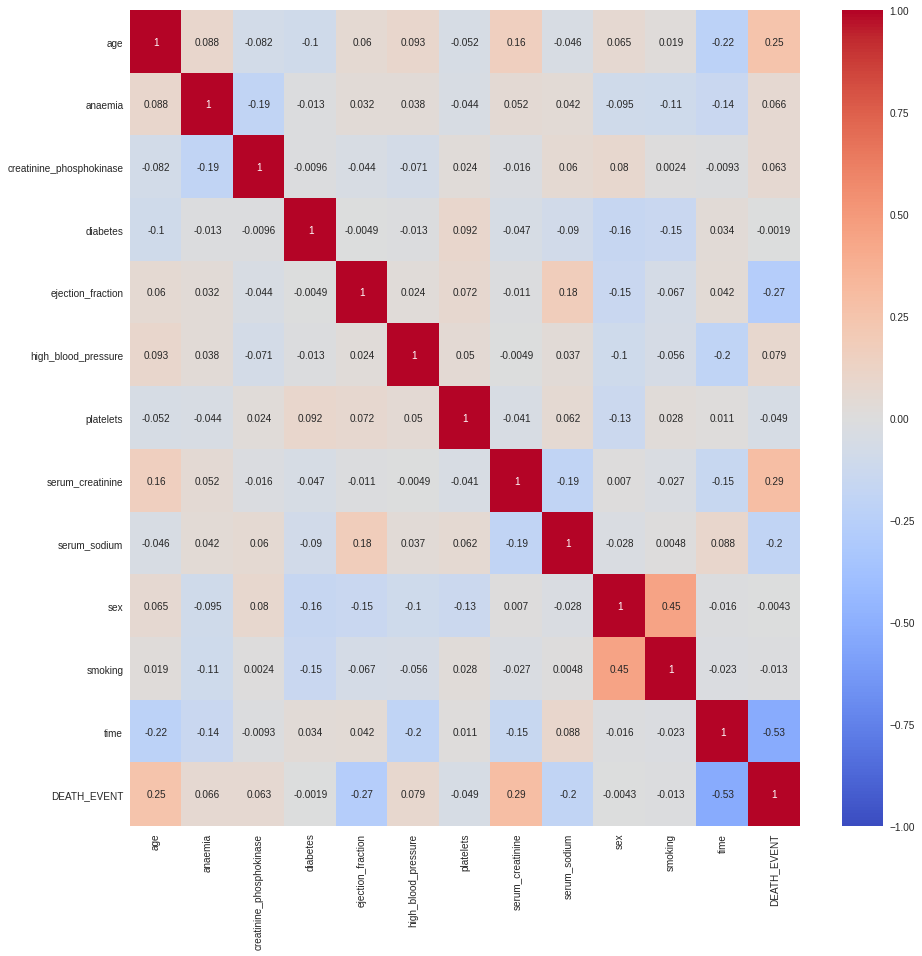

In [6]:
corr = df.corr()
ax, fig = plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmin=-1, cmap='coolwarm', annot=True)
plt.show()

In [7]:
corr[abs(corr['DEATH_EVENT']) > 0.1]['DEATH_EVENT']

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

In [8]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

# Model Building

## Basic Mode

### Training Model

In [9]:
# Select feature
x_basic = df[['age', 'anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']]
# x_basic = df[['age', 'anaemia', 'sex', 'high_blood_pressure', 'smoking']]
y_basic = df['DEATH_EVENT']

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_basic_scaled = x_basic.copy()
x_basic_scaled[['age']] = scaler.fit_transform(x_basic[['age']])

# Split dataset
from sklearn.model_selection import train_test_split
x_basic_train, x_basic_test, y_basic_train, y_basic_test = train_test_split(x_basic_scaled, y_basic, random_state=1, test_size=0.2)

# Train model
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
params = {
        'min_child_weight': [1],
        'gamma': [5],
        'subsample': [0.6],
        'colsample_bytree': [1.0],
        'max_depth': [3]
        }

xgb = XGBClassifier(learning_rate=0.01, n_estimators=1000, objective='binary:logistic')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_basic = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=-1,
                          cv=skf.split(x_basic_train, y_basic_train), verbose=0)

grid_basic.fit(x_basic_train, y_basic_train, early_stopping_rounds=30, eval_set=[(x_basic_test, y_basic_test)])

[13:06:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.69038
[1]	validation_0-logloss:0.68810
[2]	validation_0-logloss:0.68617
[3]	validation_0-logloss:0.68361
[4]	validation_0-logloss:0.68144
[5]	validation_0-logloss:0.67942
[6]	validation_0-logloss:0.67783
[7]	validation_0-logloss:0.67642
[8]	validation_0-logloss:0.67404
[9]	validation_0-logloss:0.67230
[10]	validation_0-logloss:0.67025
[11]	validation_0-logloss:0.66799
[12]	validation_0-logloss:0.66624
[13]	validation_0-logloss:0.66429
[14]	validation_0-logloss:0.66223
[15]	validation_0-logloss:0.66078
[16]	validation_0-logloss:0.65851
[17]	validation_0-logloss:0.65685
[18]	validation_0-logloss:0.65551
[19]	validation_0-logloss:0.65344
[20]	validation_0-logloss:0.65163
[21]	validation_0-logloss:0.64961
[22]	valid

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5343f5e200>,
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=None, min_child_weight=No...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
            

In [10]:
grid_basic.best_params_

{'colsample_bytree': 1.0,
 'gamma': 5,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

### Evaluating Model

Accuracy: 0.8166666666666667
Precision: 1.0
Recall: 0.21428571428571427
F1 score: 0.35294117647058826
Cohen Kappa Score: 0.29487179487179493
AUC: 0.7282608695652174


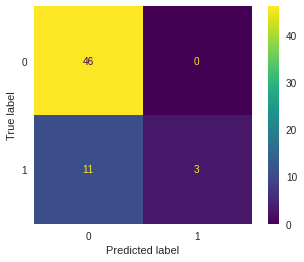

In [11]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

best_grid_basic = grid_basic.best_estimator_
best_grid_basic_pred = best_grid_basic.predict(x_basic_test)

# Calculate accuracy, precision, recall, f1-score, and kappa score
best_grid_basic_acc = metrics.accuracy_score(y_basic_test, best_grid_basic_pred)
best_grid_basic_prec = metrics.precision_score(y_basic_test, best_grid_basic_pred)
best_grid_basic_rec = metrics.recall_score(y_basic_test, best_grid_basic_pred)
best_grid_basic_f1 = metrics.f1_score(y_basic_test, best_grid_basic_pred)
best_grid_basic_kappa = metrics.cohen_kappa_score(y_basic_test, best_grid_basic_pred)

# Calculate area under curve (AUC)
best_grid_basic_pred_proba = best_grid_basic.predict_proba(x_basic_test)[::,1]
best_grid_basic_fpr, best_grid_basic_tpr, _ = metrics.roc_curve(y_basic_test,  best_grid_basic_pred_proba)
best_grid_basic_auc = metrics.roc_auc_score(y_basic_test, best_grid_basic_pred_proba)

print('Accuracy:', best_grid_basic_acc)
print('Precision:', best_grid_basic_prec)
print('Recall:', best_grid_basic_rec)
print('F1 score:', best_grid_basic_f1)
print('Cohen Kappa Score:', best_grid_basic_kappa)
print('AUC:', best_grid_basic_auc)

# Display confussion matrix
plot_confusion_matrix(best_grid_basic, x_basic_test, y_basic_test)
plt.grid(False)
plt.show()

### Save Model

In [21]:
import joblib

# Saving model
joblib.dump(best_grid_basic, 'Heart Failure Prediction (Basic).joblib')

def predict_basic(age, anaemia, diabetes, high_blood_pressure, sex, smoking):
    basic_model = joblib.load('Heart Failure Prediction (Basic).joblib') 

    predict_df = pd.DataFrame([[age, anaemia, diabetes, high_blood_pressure, sex, smoking]],
                              columns=['age', 'anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'])

    pred = basic_model.predict(predict_df)[0]

    if pred==1: return 'True'
    else: return 'False'

print(predict_basic(1, 0, 0, 0, 0, 0))
print(predict_basic(99, 1, 1, 1, 1, 1))

False
True


In [25]:
import pickle

# Save model
pickle.dump(best_grid_basic, open('basic.pkl', "wb"))

def predict_basic(age, anaemia, diabetes, high_blood_pressure, sex, smoking):
    basic_model = pickle.load(open('basic.pkl', "rb"))

    predict_df = pd.DataFrame([[age, anaemia, diabetes, high_blood_pressure, sex, smoking]],
                              columns=['age', 'anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'])

    pred = basic_model.predict(predict_df)[0]

    if pred==1: return 'True'
    else: return 'False'

print(predict_basic(1, 0, 0, 0, 0, 0))
print(predict_basic(99, 1, 1, 1, 1, 1))

False
True


## Advanced Mode

### Training Model

In [26]:
# Select feature
x_adv = df[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']]
y_adv = df['DEATH_EVENT']

# Scale data
from sklearn.preprocessing import StandardScaler
# Copying original dataframe
scaler = StandardScaler()
x_adv_scaled = x_adv.copy()
num_cols = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']
x_adv_scaled[num_cols] = scaler.fit_transform(x_adv[num_cols])
# x_adv_scaled = scaler.fit_transform(x_adv)

# Split dataset
from sklearn.model_selection import train_test_split
x_adv_train, x_adv_test, y_adv_train, y_adv_test = train_test_split(x_adv_scaled, y_adv, random_state=1, test_size=0.2)

# Train model
from xgboost import XGBClassifier
from xgboost.sklearn import XGBModel
from sklearn.metrics import roc_auc_score, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
params = {
        'min_child_weight': [1],
        'gamma': [2],
        'subsample': [0.6],
        'colsample_bytree': [1.0],
        'max_depth': [4]
        }

xgb_adv = XGBModel(learning_rate=0.01, n_estimators=5000, objective='binary:logistic')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_adv = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=-1,
                    cv=skf.split(x_adv_train, y_adv_train), verbose=0)

grid_adv.fit(x_adv_train, y_adv_train, early_stopping_rounds=30, eval_set=[(x_adv_test, y_adv_test)])

[13:20:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68954
[1]	validation_0-logloss:0.68534
[2]	validation_0-logloss:0.68069
[3]	validation_0-logloss:0.67663
[4]	validation_0-logloss:0.67368
[5]	validation_0-logloss:0.67083
[6]	validation_0-logloss:0.66718
[7]	validation_0-logloss:0.66454
[8]	validation_0-logloss:0.66063
[9]	validation_0-logloss:0.65643
[10]	validation_0-logloss:0.65253
[11]	validation_0-logloss:0.64900
[12]	validation_0-logloss:0.64572
[13]	validation_0-logloss:0.64301
[14]	validation_0-logloss:0.63977
[15]	validation_0-logloss:0.63601
[16]	validation_0-logloss:0.63350
[17]	validation_0-logloss:0.63074
[18]	validation_0-logloss:0.62713
[19]	validation_0-logloss:0.62406
[20]	validation_0-logloss:0.62072
[21]	validation_0-logloss:0.61811
[22]	valid

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5341ce3b48>,
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=None, min_child_weight=No...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
            

In [27]:
grid_adv.best_params_

{'colsample_bytree': 1.0,
 'gamma': 2,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.6}

### Evaluating Model

Accuracy: 0.85
Precision: 0.6923076923076923
Recall: 0.6428571428571429
F1 score: 0.6666666666666666
Cohen Kappa Score: 0.5700636942675159
AUC: 0.8990683229813665


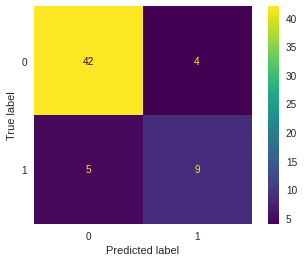

In [28]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

best_grid_adv = grid_adv.best_estimator_
best_grid_adv_pred = best_grid_adv.predict(x_adv_test)

# Calculate accuracy, precision, recall, f1-score, and kappa score
best_grid_adv_acc = metrics.accuracy_score(y_adv_test, best_grid_adv_pred)
best_grid_adv_prec = metrics.precision_score(y_adv_test, best_grid_adv_pred)
best_grid_adv_rec = metrics.recall_score(y_adv_test, best_grid_adv_pred)
best_grid_adv_f1 = metrics.f1_score(y_adv_test, best_grid_adv_pred)
best_grid_adv_kappa = metrics.cohen_kappa_score(y_adv_test, best_grid_adv_pred)

# Calculate area under curve (AUC)
best_grid_adv_pred_proba = best_grid_adv.predict_proba(x_adv_test)[::,1]
best_grid_adv_fpr, best_grid_adv_tpr, _ = metrics.roc_curve(y_adv_test,  best_grid_adv_pred_proba)
best_grid_adv_auc = metrics.roc_auc_score(y_adv_test, best_grid_adv_pred_proba)

print('Accuracy:', best_grid_adv_acc)
print('Precision:', best_grid_adv_prec)
print('Recall:', best_grid_adv_rec)
print('F1 score:', best_grid_adv_f1)
print('Cohen Kappa Score:', best_grid_adv_kappa)
print('AUC:', best_grid_adv_auc)

# Display confussion matrix
plot_confusion_matrix(best_grid_adv, x_adv_test, y_adv_test)
plt.grid(False)
plt.show()

### Save Model

In [ ]:
import joblib

# Saving model
joblib.dump(best_grid_adv, 'Heart Failure Prediction (Advanced).joblib')

def predict_advanced(age, ejection_fraction, serum_creatinine, serum_sodium):
    advanced_model = joblib.load('Heart Failure Prediction (Advanced).joblib') 

    predict_df = pd.DataFrame([[age, ejection_fraction, serum_creatinine, serum_sodium]],
                              columns=[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']])

    pred = advanced_model.predict(predict_df)[0]

    if pred==1: return 'True'
    else: return 'False'

print(predict_advanced(21, 60, 1.5, 90))
print(predict_advanced(12, 30, 2.5, 120))

True
True


In [30]:
import pickle

# Save model
pickle.dump(best_grid_adv, open('advanced.pkl', "wb"))

def predict_advanced(age, ejection_fraction, serum_creatinine, serum_sodium):
    advanced_model = pickle.load(open('advanced.pkl', "rb"))

    predict_df = pd.DataFrame([[age, ejection_fraction, serum_creatinine, serum_sodium]],
                              columns=[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium']])

    pred = advanced_model.predict(predict_df)[0]

    if pred==1: return 'True'
    else: return 'False'

print(predict_advanced(21, 60, 1.5, 90))
print(predict_advanced(12, 30, 2.5, 120))

True
True
